In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 

from aspp import Gate
from nl import NL1D

In [2]:
class SingleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 1"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
                padding_mode="reflect",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.single_conv(x)

NL1D:	    0.4127999360114336 ms
Gate:	    0.6745290882587432 ms
SingleConv: 0.2313829764574766 ms


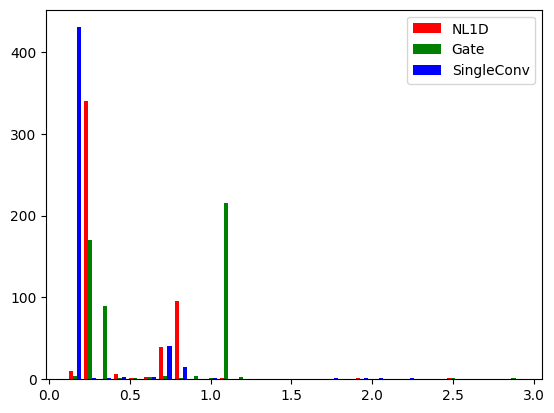

In [44]:
# Test times of the modules

in_channels = 8
mid_channels = in_channels//2
size1 = 400#1536
size2 = 32
t = 500

def timing(in_channels, mid_channels, size1, size2, t):
    gate = Gate(in_channels, mid_channels).cuda()
    nl1d = NL1D(in_channels, mid_channels).cuda()
    single_conv = SingleConv(in_channels, in_channels).cuda()


    times1 = []
    for _ in range(t):
        x = torch.randn(4, in_channels, size1, size2).cuda()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        
        start_event.record()
        y = nl1d(x)
        end_event.record()
        
        torch.cuda.synchronize()
        times1.append(start_event.elapsed_time(end_event))
    print(f"NL1D:\t    {sum(times1) / len(times1)} ms")

    times2 = []
    for _ in range(t):
        x = torch.randn(4, in_channels//2, size1, size2).cuda()
        g = torch.randn(4, in_channels, size1//2, size2//2).cuda()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        
        start_event.record()
        y = gate(x, g)
        end_event.record()
        
        torch.cuda.synchronize()
        times2.append(start_event.elapsed_time(end_event))
    print(f"Gate:\t    {sum(times2) / len(times2)} ms")

    times3 = []
    for _ in range(t):
        x = torch.randn(4, in_channels, size1, size2).cuda()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        
        start_event.record()
        y = single_conv(x)
        end_event.record()
        
        torch.cuda.synchronize()
        times3.append(start_event.elapsed_time(end_event))
    print(f"SingleConv: {sum(times3) / len(times3)} ms")
    return times1, times2, times3

times1, times2, times3 = timing(in_channels, mid_channels, size1, size2, t)
plt.hist([times1, times2, times3], bins=30, color=['r','g','b'], label=['NL1D', 'Gate', "SingleConv"])
plt.legend()